On charge le dataset et on applique nos conditions: uniquement les 6 langues latines + uniquement les phrases entre 10 et 300 caractères, on utilise également seulement 50 000 phrases par langues ce qui nous fait un total de 300 000 phrases.

In [6]:
import pandas as pd

#Read in full dataset
data = pd.read_csv('sentences.csv', sep='\t', encoding='utf8', index_col=0, names=['lang','text'])

#Filter by text length
len_cond = [True if 10<=len(s)<=300 else False for s in data['text']]
data = data[len_cond]

#Filter by text language
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
data = data[data['lang'].isin(lang)]

#Select 50000 rows for each language
data_trim = pd.DataFrame(columns=['lang','text'])

for l in lang:
    lang_trim = data[data['lang'] ==l].sample(50000,random_state = 100)
    data_trim = data_trim.append(lang_trim)

#Create a random train, valid, test split
data_shuffle = data_trim.sample(frac=1)

train = data_shuffle[0:210000]
valid = data_shuffle[210000:270000]
test = data_shuffle[270000:300000]


 


/var/folders/q1/m95rnzwj1533nyj5h86zq6080000gn/T/ipykernel_62201/4113857860.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_trim = data_trim.append(lang_trim)
/var/folders/q1/m95rnzwj1533nyj5h86zq6080000gn/T/ipykernel_62201/4113857860.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_trim = data_trim.append(lang_trim)
/var/folders/q1/m95rnzwj1533nyj5h86zq6080000gn/T/ipykernel_62201/4113857860.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_trim = data_trim.append(lang_trim)
/var/folders/q1/m95rnzwj1533nyj5h86zq6080000gn/T/ipykernel_62201/4113857860.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_tri

Feature extraction

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

def get_trigrams(corpus,n_feat=200):
    
    
    #fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char',
                            ngram_range=(3, 3)
                            ,max_features=n_feat)
    
    X = vectorizer.fit_transform(corpus)
    
    #Get model feature names
    feature_names = vectorizer.get_feature_names_out()
    
    return feature_names

In [8]:
#obtain trigrams from each language
features = {}
features_set = set()

for l in lang:
    
    #get corpus filtered by language
    corpus = train[train.lang==l]['text']
    
    #get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    
    #add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
#create vocabulary list using feature set
vocab = dict()
for i,f in enumerate(features_set):
    vocab[f]=i

In [9]:
#train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                            vocabulary=vocab)

#create feature matrix for training set
corpus = train['text']   
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)

In [10]:
#Scale feature matrix 
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)

#Add target variable 
train_feat['lang'] = list(train['lang'])

In [11]:
#create feature matrix for validation set
corpus = valid['text']   
X = vectorizer.fit_transform(corpus)

valid_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

#create feature matrix for test set
corpus = test['text']   
X = vectorizer.fit_transform(corpus)

test_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
test_feat = (test_feat - train_min)/(train_max-train_min)
test_feat['lang'] = list(test['lang'])

Modélisation du réseau de neurones

In [12]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

#Fit encoder
encoder = LabelEncoder()
encoder.fit(['deu', 'eng', 'fra', 'ita', 'por', 'spa'])

# Returns a list of one hot encoded vectors
def encode(y):
    
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

In [15]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from ann_visualizer.visualize import ann_viz

#Get training data
x = np.array(train_feat.drop('lang',axis=1))
y = np.array(encode(train_feat['lang']))

#Define model
model = Sequential()
model.add(Dense(700, input_dim=665, activation='relu'))
model.add(Dense(700, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x, y, epochs=5, batch_size=100)

#Network Visualization
ann_viz(model, title="Language detection Neural Network")

Epoch 1/5
2100/2100 [==============================] - 18s 8ms/step - loss: 0.0976 - accuracy: 0.9657
Epoch 2/5
2100/2100 [==============================] - 18s 8ms/step - loss: 0.0522 - accuracy: 0.9809
Epoch 3/5
2100/2100 [==============================] - 18s 8ms/step - loss: 0.0330 - accuracy: 0.9877
Epoch 4/5
2100/2100 [==============================] - 17s 8ms/step - loss: 0.0212 - accuracy: 0.9923
Epoch 5/5
2100/2100 [==============================] - 18s 8ms/step - loss: 0.0158 - accuracy: 0.9944


Entrainement sur les test et validation set

In [18]:
#Get test data
x_test = np.array(test_feat.drop('lang',axis=1))
y_test = np.array(encode(test_feat['lang']))

#Get validation data
x_val = np.array(valid_feat.drop('lang',axis=1))
y_val = np.array(encode(valid_feat['lang']))

#model.fit(x_test, y_test, epochs=5, batch_size=100)
model.fit(x_val, y_val, epochs=5, batch_size=100)

Epoch 1/5
600/600 [==============================] - 5s 8ms/step - loss: 0.0648 - accuracy: 0.9790
Epoch 2/5
600/600 [==============================] - 5s 8ms/step - loss: 0.0207 - accuracy: 0.9926
Epoch 3/5
600/600 [==============================] - 5s 9ms/step - loss: 0.0085 - accuracy: 0.9971
Epoch 4/5
600/600 [==============================] - 5s 8ms/step - loss: 0.0053 - accuracy: 0.9982
Epoch 5/5
600/600 [==============================] - 5s 8ms/step - loss: 0.0052 - accuracy: 0.9984


Confusion matrix

938/938 [==============================] - 2s 2ms/step
0.9908


Text(86.25, 0.5, 'Actual')

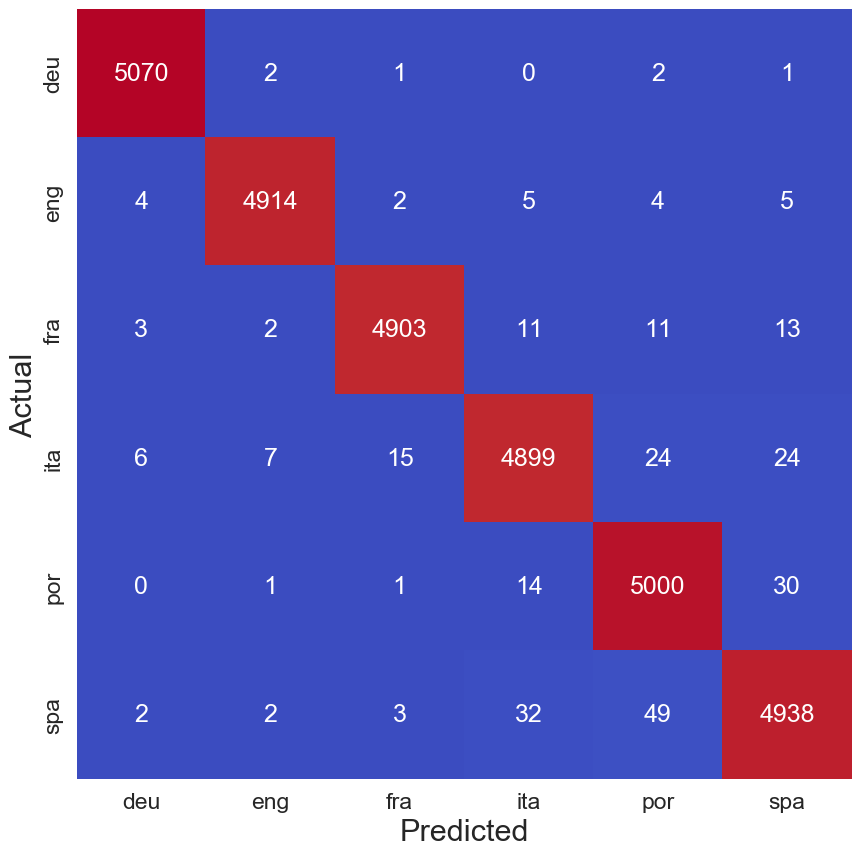

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix
import numpy as np

x_test = np.array(test_feat.drop('lang',axis=1))
y_test = np.array(test_feat['lang'])

#Get predictions on test set
labels = np.argmax(model.predict(x_test), axis = -1)
predictions = encoder.inverse_transform(labels)

#Accuracy on test set
accuracy = accuracy_score(y_test,predictions)
print(accuracy)

#Create confusion matrix
lang = ['deu', 'eng', 'fra', 'ita', 'por', 'spa']
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)